# 3D implant generation from skull scans

**Author:** Jonathan Keaveney<br>
**Date created:** 2021/06/14<br>
**Last modified:** 2021/07/06<br>
**Description:** Train a 3D convolutional neural network for prediction of crainial implant.

## Introduction

In this notebook a 3D convolutional neural network (CNN) is created to predict an implant shape suitable to replace missing crainial bone given computer tomography (CT) scans of damaged skulls.

## References
- [V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation](https://arxiv.org/pdf/1606.04797v1.pdf)
- .................................................................................................................
- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

## Setup

## Downloading the [AutoImplant challenge MICCAI dataset](https://autoimplant.grand-challenge.org/Dataset/)

Traing and test sets each consist of 100 data pairs of dimensions 512x512xZ, where Z is the number of axial slices. An additional 10 defective skulls, which have distinct (and more complicated) defects (in terms of defect shape, size and position etc) from those in the training and test set are laso provided.

In [1]:
#!pip install nbformat
#!pip install nibabel
#!pip install matplotlib
#!pip install matplotlib

In [2]:
#import nibabel as nib
import nrrd
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage
from keras import backend as K

In [2]:
%run UtilDownloads.ipynb
%run UtilData.ipynb
%run UtilScan.ipynb
%run UtilAugmentation.ipynb
%run UtilVisualise.ipynb
%run UtilLosses.ipynb

UtilDownloads loaded!
UtilData loaded!
UtilScan loaded!
UtilAugmentation loaded!
UtilVisualise loaded!
UtilLosses loaded!


## Loading data and preprocessing

The files are provided in nrrd format with the extension .nrrd. To read the scans, we use the `pynrrd` package. You can install the package via `pip install pynrrd`. CT scans 3D voxel arrays of 0s and 1s. Voxels of 0 are background and voxels of 1 are bone.

Let's read the paths of the CT scans from the class directories.

## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [3]:
# util_downloads = UtilDownloads()
# util_downloads.download_challange_scans("TrainingData")

def process_skull_scan(path):
        """Read and resize volume"""
        util_scan = UtilScan()
        # Read scan
        volume, header = util_scan.read_nrrd_file(path)
        original_shape = volume.shape
        filename = os.path.basename(path)
        # Normalize
        # volume = normalize(volume)
        # Resize width, height and depth
        #volume = resize_volume(volume)
        volume = util_scan.resizing(volume)
        return filename, original_shape, header, volume
    
util_data = UtilData()
normal_scan_filename, normal_scan_orig_dimentions, normal_scan_header, normal_scans = util_data.load_scans("TrainingData/training_set/complete_skull", process_skull_scan)
#normal_scan_filename, normal_scan_orig_dimentions,normal_scan_header, normal_scans = util_data.load_scans("TrainingData/training_set/implant", process_skull_scan)
abnormal_scan_filename, abnormal_scan_orig_dimentions, abnormal_scan_header, abnormal_scans = util_data.load_scans("TrainingData/training_set/defective_skull", process_skull_scan)
# normal_scan_orig_dimentions, normal_scans = util_data.load_scans("TrainingData/training_set/complete_skull", process_skull_scan)
# abnormal_scan_orig_dimentions, abnormal_scans = util_data.load_scans("TrainingData/training_set/defective_skull", process_skull_scan)

# test_scans = util_data.load_scans("TrainingData/test_set_for_participants", process_skull_scan)
# additional_test_scans = util_data.load_scans("TrainingData/additional_test_set_for_participants", process_skull_scan)

# Split into train and test sets
x_train, y_train, x_val, y_val = util_data.train_test_split(70, normal_scans, abnormal_scans)

# make a corrisponding split for filename, original dimensions and header data
# - filesname is uses to save prediction with same name as original so that later comparison can easily be done
# - orig dimintions are needed to return prediction to original size
# - header is required to calculate HD as space dimnetions are included in nrrd header
x_train_filename, y_train_filename, x_val_filename, y_val_filename = util_data.train_test_split(70, normal_scan_filename, abnormal_scan_filename)
x_train_orig_dimentions, y_train_orig_dimentions, x_val_orig_dimentions, y_val_orig_dimentions = util_data.train_test_split(70, normal_scan_orig_dimentions, abnormal_scan_orig_dimentions)
x_train_header, y_train_header, x_val_header, y_val_headers = util_data.train_test_split(70, normal_scan_header, abnormal_scan_header)
    
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

#train_dataset, validation_dataset = define_data_loaders(2)

Number of samples in train and validation are 70 and 30.


In [4]:
# read file headers
#[print(path + ': ' + str(read_nrrd_header(path)['sizes'])) for path in abnormal_scan_paths]
#[read_nrrd_header(path) for path in normal_scan_paths]

## Data augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already rescaled to have values between 0 and 1.

In [4]:
def define_data_loaders(batch_size):


    def train_preprocessing(volume, label):
        """Process training data by rotating and adding a channel."""
        # Rotate volume
        #volume, label = UtilAugmentation.rotate(volume, label)
        volume = tf.expand_dims(volume, axis=3)
        label = tf.expand_dims(label, axis=3)
        return volume, label


    def validation_preprocessing(volume, label):
        """Process validation data by only adding a channel."""
        volume = tf.expand_dims(volume, axis=3)
        label = tf.expand_dims(label, axis=3)
        return volume, label
    
    train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    # Augment the on the fly during training.
    train_dataset = (
        train_loader.shuffle(len(x_train))
        .map(train_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    # Only rescale.
    validation_dataset = (
        validation_loader.shuffle(len(x_val))
        .map(validation_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    
    return train_dataset, validation_dataset

In [6]:
train_dataset, validation_dataset = define_data_loaders(4)

Visualize an augmented CT scan.

Dimension of the CT scan is: (128, 128, 64, 1)


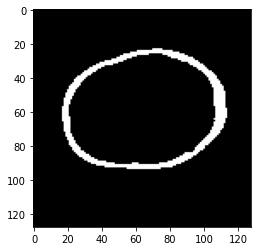

In [6]:
UtilVisualise.plot_slice(train_dataset.take(1))
#UtilVisualise.plot_slice(x_train)
# images, labels = list(train_dataset.take(1))[0]
# images = images.numpy()
# image = images[0]
# print("Dimension of the CT scan is:", image.shape)
# plt.imshow(np.squeeze(image[:, :,30]), cmap="gray")

Since a CT scan has many slices, let's visualize a montage of the slices.

Feature Image #0 - 6 rows and 10 columns for 60 slices of the CT scan


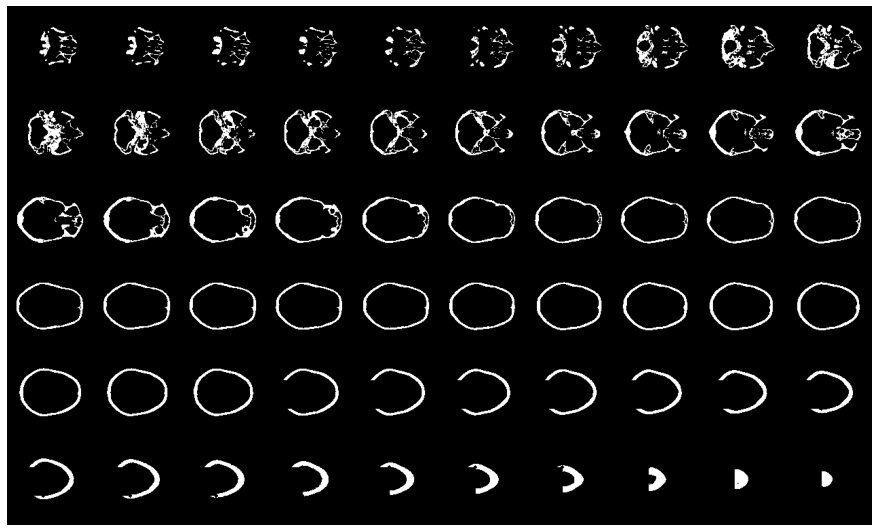

Label Image #0 - 6 rows and 10 columns for 60 slices of the CT scan


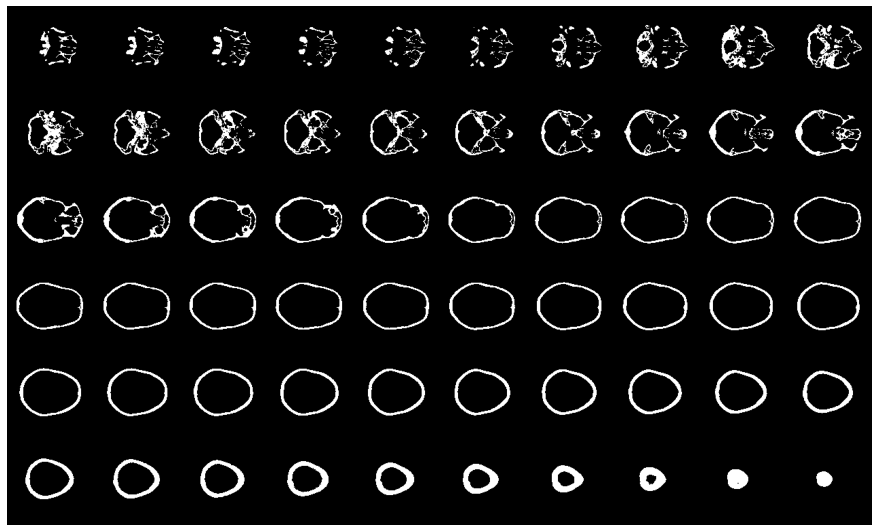

In [7]:
# 6 rows and 10 columns for 100 slices of the CT scan.
imgNum = 0
print("Feature Image #" + str(imgNum) + " - 6 rows and 10 columns for 60 slices of the CT scan")
UtilVisualise.plot_slices(6, 10, 128, 128, x_train[0][:, :, :60])
print("Label Image #" + str(imgNum) + " - 6 rows and 10 columns for 60 slices of the CT scan")
UtilVisualise.plot_slices(6, 10, 128, 128, y_train[0][:, :, :60])

## Loss Functions

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [7]:
def get_unet(filtersValue, width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
    
    conv1 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = layers.MaxPool3D(pool_size=(2, 2, 2))(conv1)
    conv2 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = layers.MaxPool3D(pool_size=(2, 2, 2))(conv2)
    conv3 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = layers.MaxPool3D(pool_size=(2, 2, 2))(conv3)
    conv4 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPool3D(pool_size=(2, 2, 2))(drop4)

    conv5 = layers.Conv3D(filtersValue*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = layers.Conv3D(filtersValue*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    up6 = layers.Conv3D(filtersValue*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(drop5))
    merge6 = layers.concatenate([drop4,up6], axis = 4)
    conv6 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = layers.Conv3D(filtersValue*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 4)
    conv7 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = layers.Conv3D(filtersValue*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 4)
    conv8 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = layers.Conv3D(filtersValue, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 4)
    conv9 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = layers.Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    out = layers.Conv3D(1, 3, activation = 'sigmoid', padding = 'same')(conv9)
    #out = layers.Conv3D(1, 3, activation = 'softmax', padding = 'same')(conv9)
    
    model = keras.Model(inputs = inputs, outputs = out, name="3dcnn")
    #model.compile(optimizer = "sgd", loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

#     merge9 = concatenate([conv1,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

#     model = Model(inputs = inputs, outputs = conv10)


## Train model

In [12]:
# Build model.
model = get_unet(filtersValue=32, width=128, height=128, depth=64)
model.summary(line_length=150)

# Defin data loaders
#train_dataset, validation_dataset = define_data_loaders(4)

# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    #loss="binary_crossentropy",
    #loss=UtilLosses.dice_loss,
    #loss="sparse_categorical_crossentropy",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    #loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    # what metric is used depends on loss fn. for cust (see om we ned up with categorical_accuracy 
    # (see https://github.com/keras-team/keras/blob/68dc181a5e34d1f20edabe531176b3bfb50001f9/keras/engine/training.py#L375)
    #metrics=["acc"]
    metrics=[UtilLosses.dice_coeff]
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_implant_generation007.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_dice_coeff", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 30
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)


Model: "3dcnn"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_3 (InputLayer)                             [(None, 128, 128, 64, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_46 (Conv3D)                               (None, 128, 128, 64, 32)         896               input_3[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv3d_47 (Conv3D)                               (None, 128, 128, 64, 32)      

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

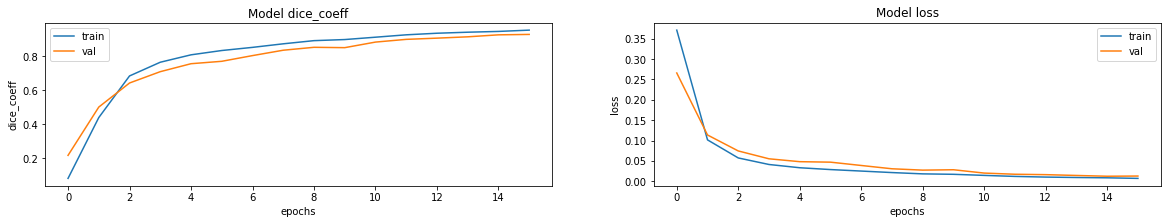

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

#for i, metric in enumerate(["acc", "loss"]):
for i, metric in enumerate(["dice_coeff", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [54]:
#np.unique(implant_prediction)
#implant_prediction.flatten()
#np.bincount(implant_prediction.flatten())

unique_elements, counts_elements = np.unique(implant_prediction, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     -1       0       1]
 [     41 1044298    4237]]


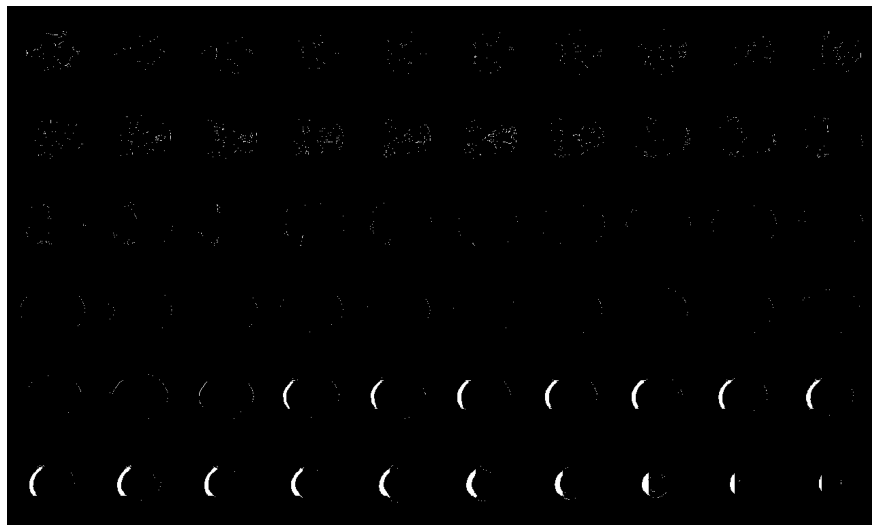

tf.Tensor(0.67140526, shape=(), dtype=float32)


In [14]:
prediction = model.predict(np.expand_dims(x_val[2], axis=0))[0]
prediction=np.where(prediction>0.5,1,0)
implant_prediction = np.abs(prediction[:,:,:,0]-x_val[2])
implant = y_val[2]-x_val[2]
UtilVisualise.plot_slices(6, 10, 128, 128, implant_prediction[:, :, :60])
print(UtilLosses.dice_coeff(implant,implant_prediction))
#print(UtilLosses.benchmark_dice_coeff(y_val[2],x_val[2]))

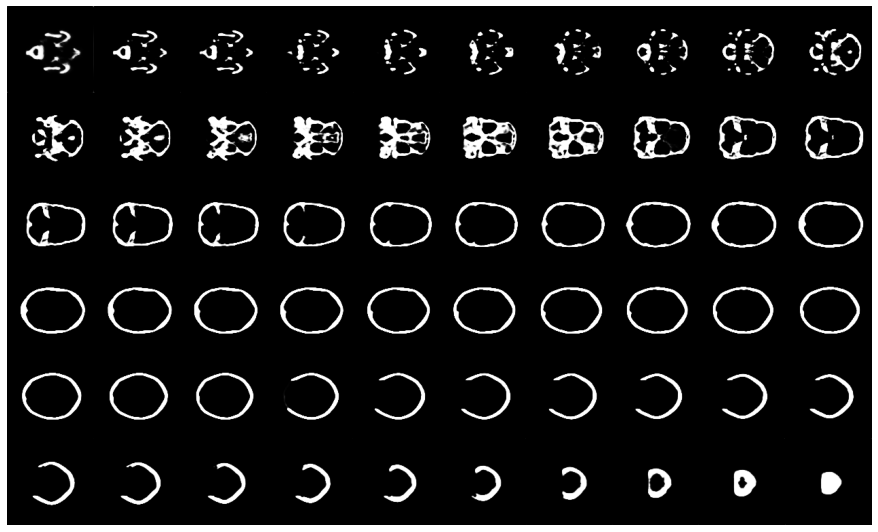

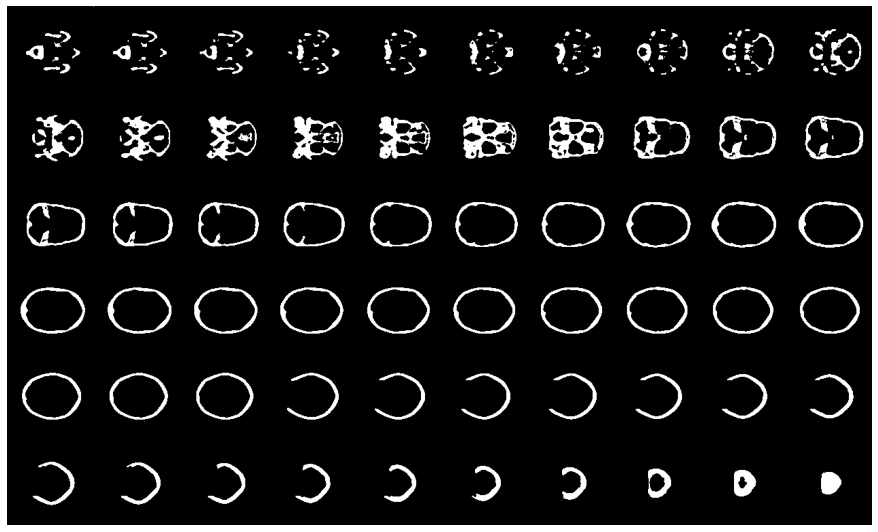

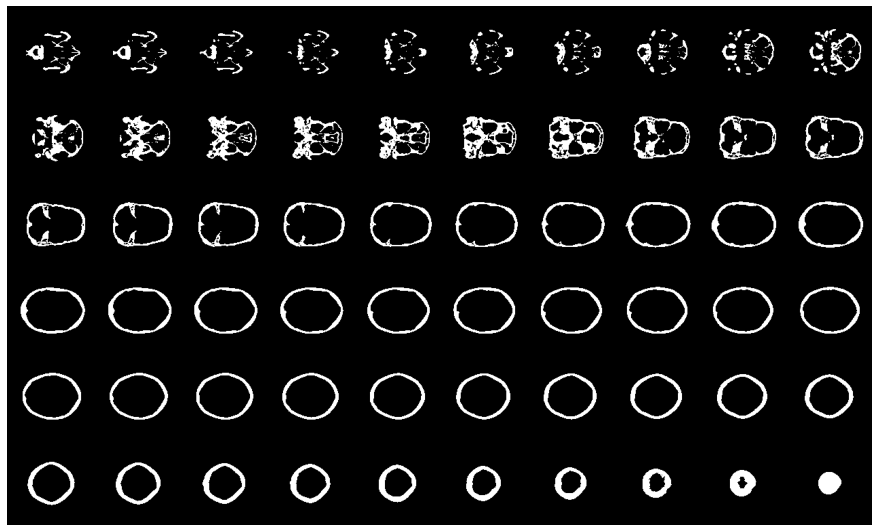

In [22]:
# make prediction and look at histogram of prediction
prediction = model.predict(np.expand_dims(x_val[2], axis=0))[0]
UtilVisualise.plot_slices(6, 10, 128, 128, prediction[:, :, :60])
prediction=np.where(prediction>0.5,1,0)
UtilVisualise.plot_slices(6, 10, 128, 128, prediction[:, :, :60])
UtilVisualise.plot_slices(6, 10, 128, 128, y_val[2,:, :, :60])
#dice_loss_scores.append(dice_loss(prediction[:,:,:,0],y_val[i].astype('float32')).numpy())

(128, 128, 64, 2)


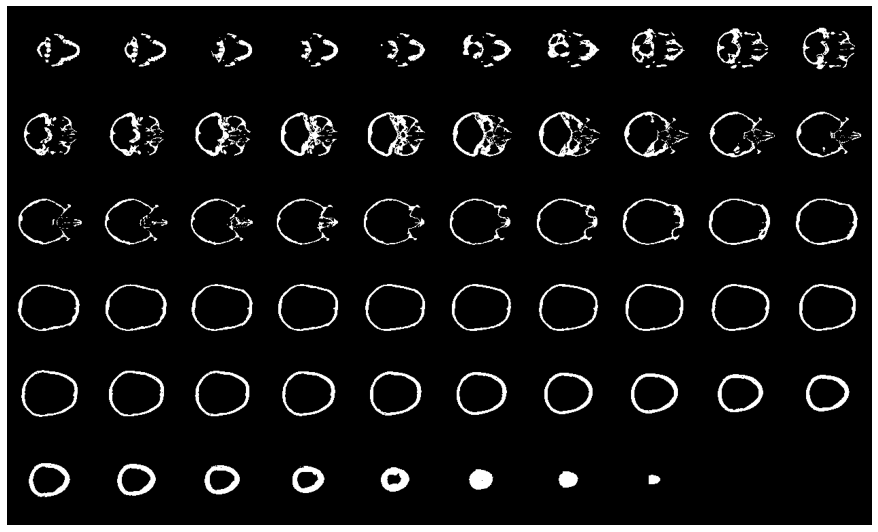

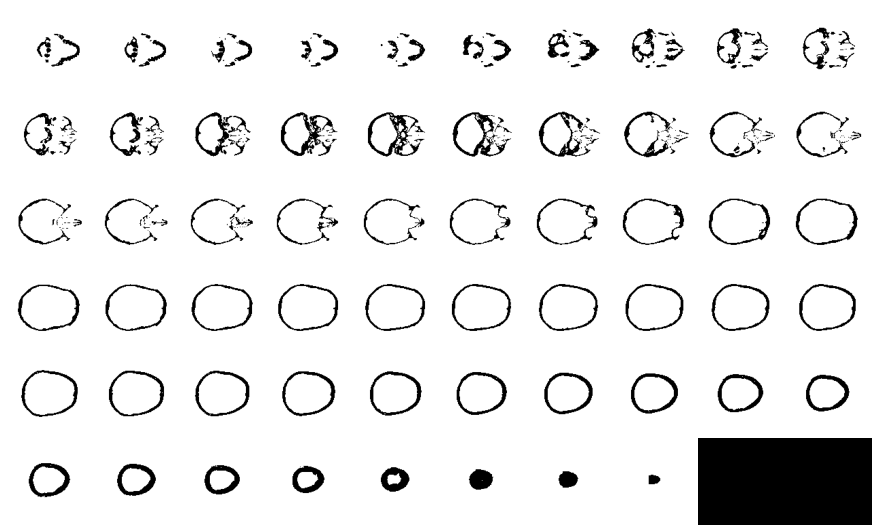

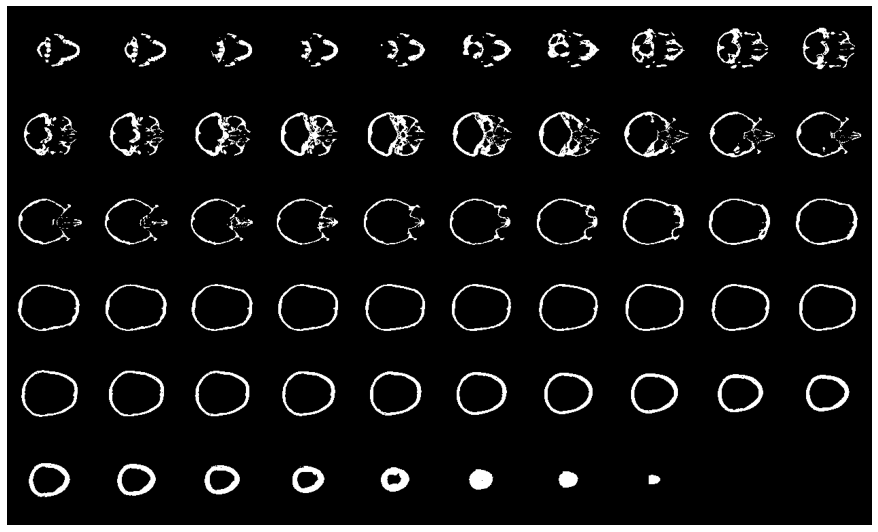

In [176]:
# Look at what one hot does
prediction = model.predict(np.expand_dims(x_val[20], axis=0))[0]
prediction=np.where(prediction>0.5,1,0)
one_hot_p = tf.squeeze(tf.one_hot(prediction, 2), axis=3)
print(one_hot_p.shape)
UtilVisualise.plot_slices(6, 10, 128, 128, prediction[:,:, :60])
UtilVisualise.plot_slices(6, 10, 128, 128, one_hot_p[:, :, :60, 0])
UtilVisualise.plot_slices(6, 10, 128, 128, one_hot_p[:, :, :60, 1])
#UtilVisualise.plot_slices(6, 10, 128, 128, y_val[20,:, :, :60])
#dice_loss_scores.append(dice_loss(prediction[:,:,:,0],y_val[i].astype('float32')).numpy())
#tf.one_hot(prediction, 2)

[997392     99     63     60     46     52     47     84    119  50614]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


(array([9.97392e+05, 9.90000e+01, 6.30000e+01, 6.00000e+01, 4.60000e+01,
        5.20000e+01, 4.70000e+01, 8.40000e+01, 1.19000e+02, 5.06140e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

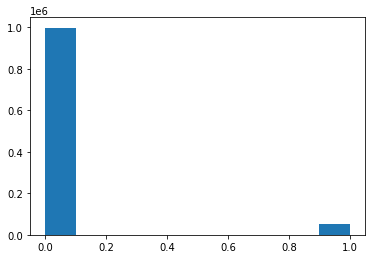

In [105]:
from matplotlib import pyplot as plt 
hist, bins = np.histogram(prediction[:,:,:,0])
print(hist)
print(bins)
plt.hist(prediction[:,:,:,0].flatten()) 

### Hausdorff Distance

In [16]:
#print(x_train_filename)
#print(x_train_orig_dimentions)
print(x_train_header[0:3])

[OrderedDict([('type', 'int32'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([512, 512, 256])), ('space directions', array([[0.488281, 0.      , 0.      ],
        [0.      , 0.488281, 0.      ],
        [0.      , 0.      , 0.625   ]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([-125.   , -135.9  ,  -20.688]))])
 OrderedDict([('type', 'int32'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([512, 512, 245])), ('space directions', array([[0.505859, 0.      , 0.      ],
        [0.      , 0.505859, 0.      ],
        [0.      , 0.      , 0.625   ]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([-129.5       , -162.80000305,  -10.5       ]))])
 OrderedDict([('type', 'int32'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([512, 512, 240])), ('space directions', array([[0.443359

It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

### Experiment filterValue=16 & epochs=8
 - output of sigmoid output layer is good (mostly near zero and near ones) and prediction images look good
 
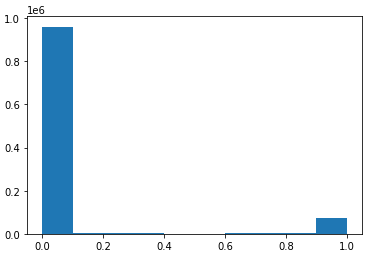
     
 - For single softmax learning is not occurring and outpit is all ones
 - removing sigmoid from loss doesn't seem to do much. which makes sense as output layer is sigmoid
 - thresholding increases DSC
   thresholding at [0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999, 0.99999, 0.999999] 
   gives DSCs of [0.7681938877142555, 0.8049099620040847, 0.8393978397254699, 0.8543330582746599, 0.8448473993402346, 0.8046880237647214, 0.8046880237647214, 0.7287758097917774]
   so 0.9999 seems to be best threshold



### Experiment filterValue=32 & epochs=20
Concerningly good results when tresholding at "for ls in np.linspace(0,1,20):" we get
[0.15927857413804283, 0.9875876203790004, 0.9873018210992999, 0.9870795105653476, 0.9868714907734795, 0.9867309645308862, 0.9865571122354689, 0.9864092342550901, 0.9862668740245635, 0.9861462187632213, 0.9859937555400778, 0.9858618316508749, 0.9856798755004705, 0.9854726514101906, 0.9852216733752659, 0.9849310927474105, 0.9844885507611574, 0.9838000515419468, 0.9825103311347666, 0.0]
Saved the model to "3d_implant_generation004.h5"

The high score made me look at the benchmarh loss function. The dimentions were dfferent but after changing that the results were arount e-6 which doesn't make sense. The loss function used reduce_mean for calculating the numerator which is just average and cannot represent intersection to my mind. Changing to reduce_sum gave simular results to mine. Also, all other examples i've seen use K.sum or K.dot which is in line with reduce_sum. So concluding my function is right. **Note: these results are much better than i got before. I wonder is that due to removing sigmoid from loss. Need to understand this to ave confidince on results.** 

One way to confirm the results would be to submit some test results to challange website but this seems to be closed. There is a 2021 challange so submission could be available for that and results could varify my model.

Updated benchmark_dice_coeff(0 to work with my dimentions as seemed to be getting dice for background and dice for bone and averaging. Results were betting ;-)

[0.32884112000465393, 0.9934131860733032, 0.9932607531547546, 0.9931422710418701, 0.9930315971374511, 0.9929566621780396, 0.9928642511367798, 0.9927855610847474, 0.992709732055664, 0.9926453828811646, 0.9925644278526307, 0.9924943685531616, 0.9923973798751831, 0.9922873258590699, 0.9921539425849915, 0.991999626159668, 0.991764497756958, 0.9913989424705505, 0.9907139539718628, 0.4846120059490204]

### Experiment filterValue=32 & epochs=20 - predict implant
Loss stayed at 1.0 so no learning strangely. Repeate dd with batch size of 4 but still the same results.

### Experiment filterValue=32 & epochs=20 & batch size = 4 - back to predict complete skull
 - Try 2 things - get a single score for prediction (maybe validation should do this)
 - Get prediction saved to a nrrd file
 - Calc HD value
 - Note: in this exp i removed astype("float32") from train_test_split - reminder incase results change
 
 Ran for 5 epocs and got
 loss: 0.1338 - dice_coeff: 0.8666 - val_loss: 0.1246 - val_dice_coeff: 0.8760
 
 Realised thet the DSC is to be calculated on implant alone. So I need to subtract defect from prediction and compare to defect - label to get correct DSC
 Reloaded model from "3d_implant_generation004.h5" and got a DSC of 0.8782060404618581 on validation set.

### Experiment filterValue=32 & epochs=20 & batch size = 4 - with random rotations

saving to "3d_implant_generation006.h5"

Training stopped at 16 of 30 epochs when it reached val_dice_coeff: 0.9763. I think as the space of the scan is large the increments made, per epoch, are small at the end but still useful. As going from 0.9763 to 0.99 over a futher 10-15 epochs is useful to me. Note, this is worse than the 0.99 odd achieved without ratation so looks like rotation is not useful. I also change batch size for 2 to 4 but don't think that could contribute to decrease. We should try remove rotation and reduce variability going into the model.

Getting DSC of 0.8780460755030314 on entire validation set. Note added np.abs() around difference between prediction and defect as notices that some values wer -1 where prediction=0 and defect=1. I think this is ok inpassing predicted implant into DSC calc

### Experiment filterValue=48 & epochs=20 & batch size = 4 - without random rotations
saving to "3d_implant_generation006.h5"

Notebook looked like it ran but Mem showed no increase and indicator said idle and not bus so think it wasn't running. Tried filterValue=42 and that ran but loss wen to 1 on epoch 2 and stayed there. Tried filterValue=38 and tha ran to val_dice_coeff: 0.9821.
On entire validation set getting 
DCS of 0.8426057696342468
Benchmart DCS of 0.9208967586358389
Oddly this is worse than the 0.8780460755030314 achieven with 5 epochs above.

Looking back at and running predictions on validation set i get
DCS = 0.8780460755030314
Benchmart DCS = 0.9387214601039886
So i guess the 0.8780460755030314 value was from "3d_implant_generation004.h5" and not "3d_implant_generation005.h5". Checking this i ran validation set for "3d_implant_generation005.h5" and got
DCS = 0.018867236220588286
Benchmart DCS 0.5062479615211487
A bit confuesd now. Lets move on.

### Experiment filterValue=32 & epochs=20 & batch size = 10 - without random rotations

saving to "3d_implant_generation007.h5"

Didn't seem to run. Trying batch size of 6. Same again. Trying batch size of 5. Still fails.

Try "categorical_crossentropy" - loss stays as zero

Trying "sparse_categorical_crossentropy" -  errors out with "Received a label value of 1 which is outside the valid range of [0, 1)"

Trying tf.keras.losses.BinaryCrossentropy(from_logits=False)
Epoch 16/30
18/18 - 571s - loss: 0.0073 - dice_coeff: 0.9551 - val_loss: 0.0130 - val_dice_coeff: 0.9299
DCS = 0.6100041190783183
Benchmart DCS = 0.8039308249950409

## Make predictions on a single CT scan

In [155]:
for i in np.linspace(0.9999,1,20):
    print(i, end=', ')

0.9999, 0.9999052631578947, 0.9999105263157895, 0.9999157894736842, 0.9999210526315789, 0.9999263157894737, 0.9999315789473684, 0.9999368421052631, 0.9999421052631579, 0.9999473684210526, 0.9999526315789474, 0.9999578947368422, 0.9999631578947369, 0.9999684210526316, 0.9999736842105263, 0.9999789473684211, 0.9999842105263158, 0.9999894736842105, 0.9999947368421053, 1.0, 

In [ ]:
predictions = []

for i in range(y_val.shape[0]):
    prediction= model.predict(np.expand_dims(x_val[i], axis=0))[0]
    predictions.append(prediction)

In [ ]:
#!pip install sklearn
# model.load_weights("3d_implant_generation003.h5")
avg_dice_loss_scores = []
# predictions = []

# for i in range(y_val.shape[0]):
#     prediction= model.predict(np.expand_dims(x_val[i], axis=0))[0]
#     predictions.append(prediction)
    
#print(np.logspace(1,0.99,50)/10)
for ls in np.linspace(0,1,20):
#for ls in [0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999, 0.99999, 0.999999]: #np.logspace(1,0.99,50)/10: #np.linspace(0,1,20):
    dice_loss_scores = []
    #for i in range(y_val.shape[0]):
    for i in range(5):
        prediction = predictions[i]
        
#         print(prediction[:,:,:,0].shape)
#         print(y_val[i].shape) 
        #dice_loss_scores.append(DiceLoss(np.where(prediction[:,:,:,0]>ls,1,0),y_val[i].astype('float32')).numpy())
        #dice_loss_scores.append(dice_coef(np.where(prediction[:,:,:,0]>ls,1,0),y_val[i].astype('float32')).numpy())
#         if(i==1):
#             print(ls)
#             UtilVisualise.plot_slices(6, 10, 128, 128,np.where(prediction[:,:,:,0]>ls,1,0)[:, :, :60])
        dice_loss_scores.append(UtilLosses.benchmark_dice_coeff(np.where(prediction[:,:,:,0]>ls,1,0),y_val[i]).numpy())
        

    avg_dice_loss_scores.append(sum(dice_loss_scores) / len(dice_loss_scores))
    


# import scipy
# from sklearn.metrics import accuracy_score

# def thr_to_accuracy(thr, y_val, predictions):
#    return -accuracy_score(y_val, np.array(predictions>thr, dtype=np.int))

# i = 0
# prediction = model.predict(np.expand_dims(x_val[i], axis=0))[0]
# best_thr = scipy.optimize.fmin(thr_to_accuracy, args=(y_val[i].astype('float32'), prediction.astype('float32')), x0=0.5)
# print(best_thr) 0.7988993108272553, 0.8067788561185201, 0.8263887107372284, 0.8588930189609527

# 0.61966314315795, 0.6614419718583425, 0.6997271835803985, 0.7296699345111847

In [ ]:
print(avg_dice_loss_scores)

In [82]:
print(np.unique(y_val[0]))
print(np.unique(predictions[0]))
print(np.unique(np.where(predictions[0][:,:,:,0]>0.5,1,0)))
print(np.where(predictions[0][:,:,:,0]>0.5,1,0).dtype)

[0. 1.]
[0.0000000e+00 1.1760917e-38 1.1771061e-38 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]
[0 1]
int64


In [16]:
model = get_unet(filtersValue=32, width=128, height=128, depth=64)
model.load_weights("3d_implant_generation007.h5")

dice_loss_scores = []
benchmark_dice_loss_scores = []
for i in range(y_val.shape[0]):
    prediction = model.predict(np.expand_dims(x_val[i], axis=0))[0]
    prediction=np.where(prediction>0.5,1,0)
    implant_prediction = abs(prediction[:,:,:,0]-x_val[i])
    implant = y_val[i]-x_val[i]
    #dice_loss(prediction[:,:,:,0],y_val[i].astype('float32')
    dl = UtilLosses.dice_coeff(implant,implant_prediction)
    dice_loss_scores.append(UtilLosses.dice_coeff(implant,implant_prediction).numpy())
    benchmark_dice_loss_scores.append(UtilLosses.benchmark_dice_coeff(implant,implant_prediction).numpy())

print(sum(dice_loss_scores) / len(dice_loss_scores))
print(sum(benchmark_dice_loss_scores) / len(benchmark_dice_loss_scores))

#prediction = model.predict(np.expand_dims(x_val[2], axis=0))[0]
#prediction=np.where(prediction>0.5,1,0)
#implant_prediction = prediction[:,:,:,0]-x_val[2]
#implant = y_val[2]-x_val[2]
#UtilVisualise.plot_slices(6, 10, 128, 128, implant_prediction[:, :, :60])
#print(UtilLosses.dice_coeff(implant,implant_prediction))

0.6100041190783183
0.8039308249950409


dsc = 0.8710173527399699 using loss="categorical_crossentropy" for filtersValue=4 (300K paramaters) - loss is flat & output doesn't look like skull

dsc = 0.6751154164473215 using dice_loss for filtersValue=4 (300K paramaters) - some shape but poor mimic of skull

dsc = 0.7409667948881785 for filtersValue=8 (1.4 million paramaters)

dsc = X for filtersValue=16 (5.6 million paramaters)

dsc = X for filtersValue=16 (5.6 million paramaters) with random rotations in training

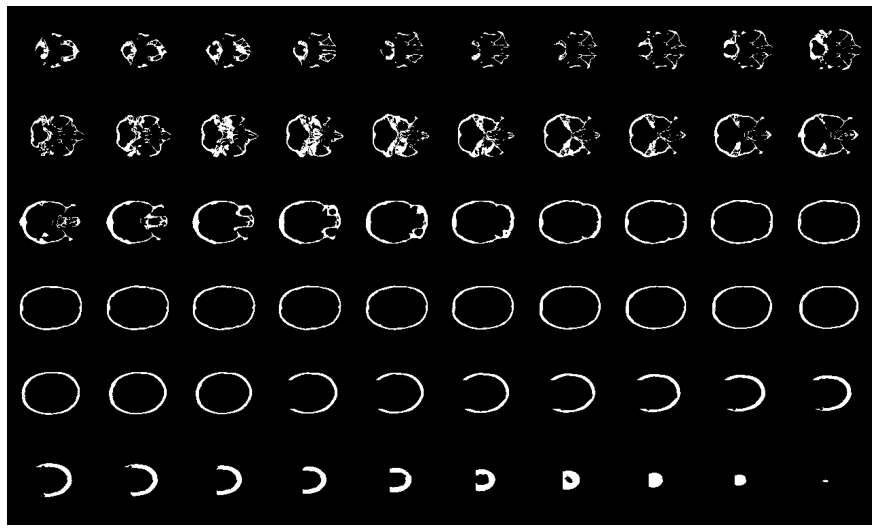

NameError: name 'model' is not defined

In [21]:
UtilVisualise.plot_slices(6, 10, 128, 128,x_val[3][:, :, :60])
p=model.predict(np.expand_dims(x_val[3], axis=0))[0]
UtilVisualise.plot_slices(6, 10, 128, 128,p[:, :, :60])
UtilVisualise.plot_slices(6, 10, 128, 128,np.where(p[:,:,:,0]>0.9999,1,0)[:, :, :60])
UtilVisualise.plot_slices(6, 10, 128, 128,y_val[3][:, :, :60])

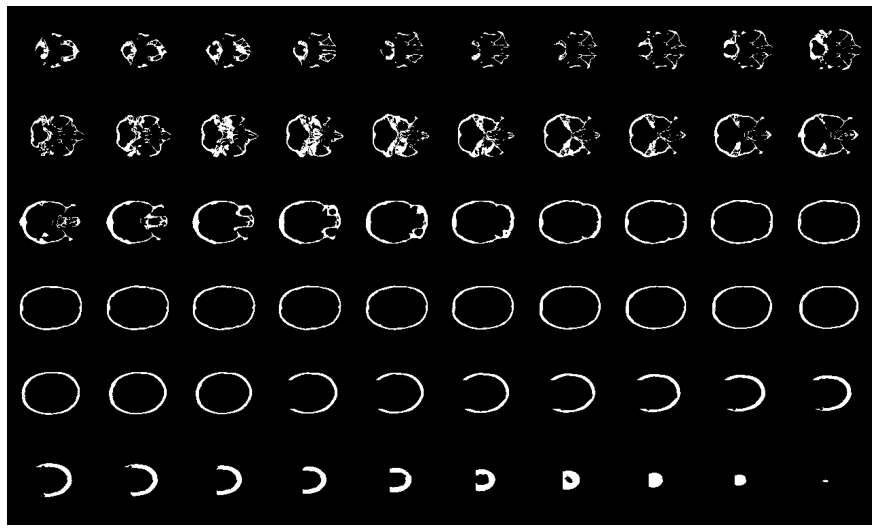

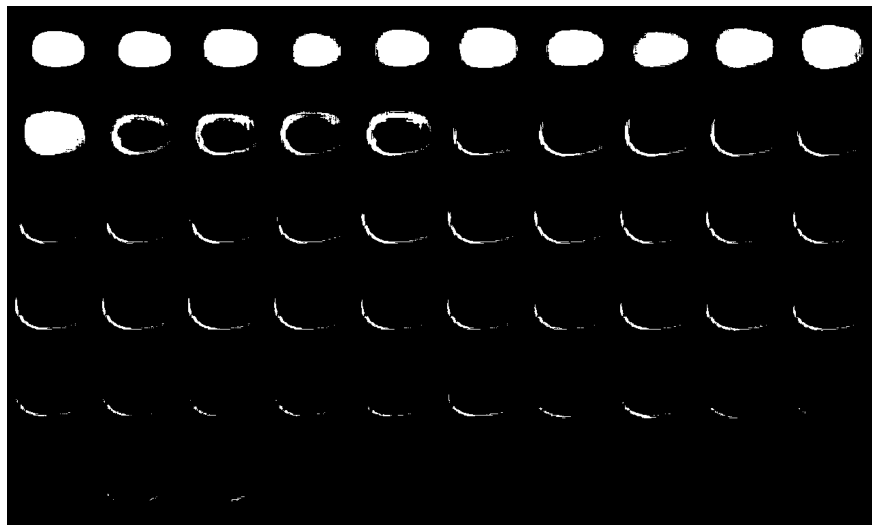

In [28]:
UtilVisualise.plot_slices(6, 10, 128, 128,x_val[3][:, :, :60])
p=model.predict(np.expand_dims(x_val[3], axis=0))[0]
UtilVisualise.plot_slices(6, 10, 128, 128,np.where(p>0.999999,1,0)[:, :, :60])

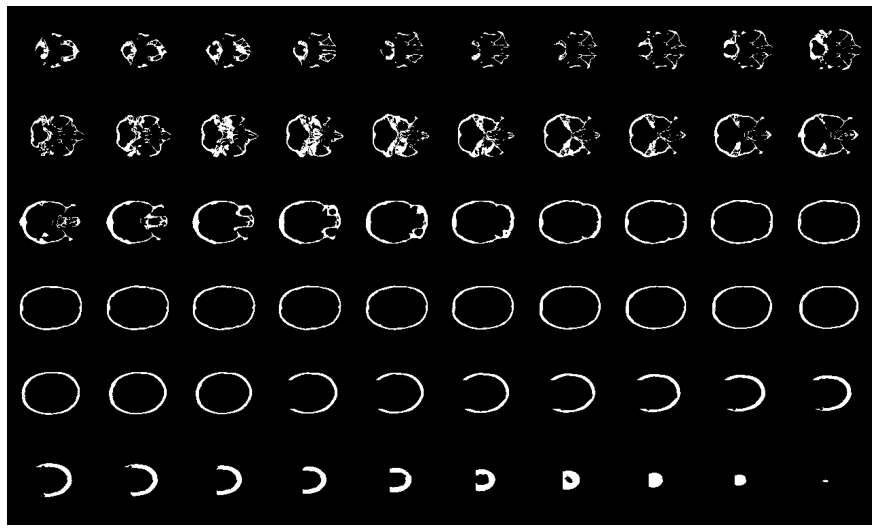

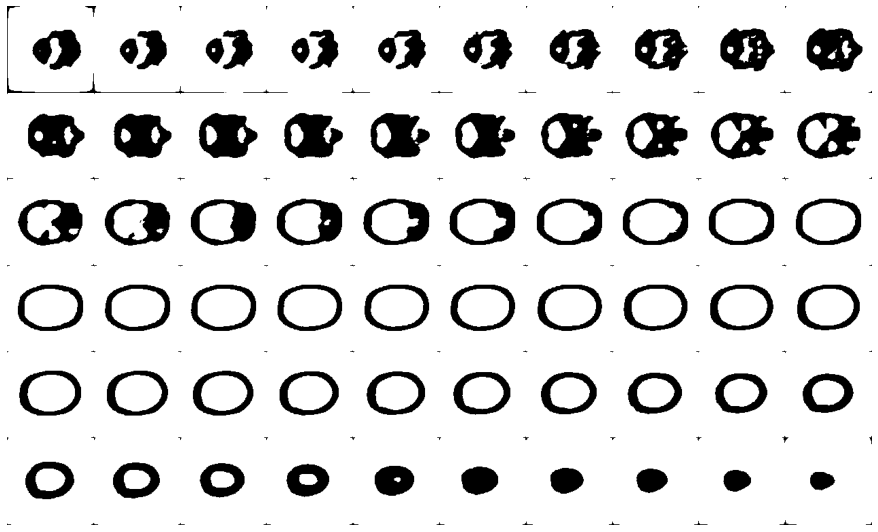

In [63]:
UtilVisualise.plot_slices(6, 10, 128, 128,x_val[3][:, :, :60])
p=model.predict(np.expand_dims(x_val[3], axis=0))[0]
UtilVisualise.plot_slices(6, 10, 128, 128,p[:, :, :60])
UtilVisualise.plot_slices(6, 10, 128, 128,np.where(p>0.1,1,0)[:, :, :60])

In [37]:
model.evaluate(np.expand_dims(abnormal_scans[3], axis=0), np.expand_dims(normal_scans[3], axis=0))

1/1 [==============================] - 0s 390ms/step - loss: 0.8628 - acc: 0.9817


[0.8627868890762329, 0.9817333221435547]

In [27]:
p.shape

(128, 128, 64, 1)

In [51]:
# Load best weights.
model.load_weights("3d_implant_generation001.h5")
#prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]

prediction = model.predict(np.expand_dims(abnormal_scans[3], axis=0))[0]
#prediction = model.predict(np.expand_dims(normal_scans[0], axis=0))[0]
prediction.shape

filename = os.path.join(os.getcwd(), "prediction4.nrrd")
nrrd.write(filename, np.where(prediction>0.9999,1,0)[:,:,:,0])
#np.where(p>0.9999,1,0)

# header = {'kinds': ['domain', 'domain', 'domain'], 'units': ['mm', 'mm', 'mm'], 'spacings': [1.0458, 1.0458, 2.5], 'space': 'right-anterior-superior', 'space directions': np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), 'encoding': 'ASCII', 'custom_field_here1': 24.34, 'custom_field_here2': np.array([1, 2, 3, 4])}
# custom_field_map = {'custom_field_here1': 'double', 'custom_field_here2': 'int list'}
# header = {'kinds': ['domain', 'domain', 'domain'], 'units': ['mm', 'mm', 'mm'], 'spacings': [1.0458, 1.0458, 2.5], 'space': 'right-anterior-superior', 'space directions': np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), 'encoding': 'ASCII', 'custom_field_here1': 24.34, 'custom_field_here2': np.array([1, 2, 3, 4])}
# custom_field_map = {'custom_field_here1': 'double', 'custom_field_here2': 'int list'}
# nrrd.write(filename, data, header, custom_field_map=custom_field_map)

# scores = [1 - prediction[0], prediction[0]]

# class_names = ["normal", "abnormal"]
# for score, name in zip(scores, class_names):
#     print(
#         "This model is %.2f percent confident that CT scan is %s"
#         % ((100 * score), name)
#     )

In [35]:
data,hd=nrrd.read('./TrainingData/training_set/complete_skull/000.nrrd')
print(hd)

OrderedDict([('type', 'int32'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([512, 512, 237])), ('space directions', array([[ 0.451172  ,  0.        ,  0.        ],
       [ 0.        ,  0.44561735, -0.07057867],
       [ 0.        ,  0.09902267,  0.62520619]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([-120.2       , -127.84611718,  -10.21586356]))])


In [68]:
data,hd=nrrd.read('prediction3.nrrd')
print(hd)

OrderedDict([('type', 'float'), ('dimension', 3), ('sizes', array([128, 128,  64])), ('endian', 'little'), ('encoding', 'gzip')])


In [65]:
np.where(prediction[:,:,:,0] > 0.1, 1, 0).shape

(128, 128, 64)

In [69]:
#print(np.unique(np.where(data > 0.1, 1, 0)))
print(np.unique(data))

[0.0000000e+00 1.1759482e-38 1.1763609e-38 ... 9.9999982e-01 9.9999988e-01
 1.0000000e+00]


In [70]:
np.histogram(data)
#np.histogram(data)

(array([968075,   2546,   1599,   1252,   1182,   1220,   1265,   1526,
          2221,  67690]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

In [18]:
model.load_weights("3d_implant_generation001.h5")
#prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]

prediction = model.predict(np.expand_dims(abnormal_scans[3], axis=0))[0]
data = validation_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :,30]), cmap="gray")

NameError: name 'validation_dataset' is not defined

## Thinks to look at
 - Receptiv field
 - preprocessing step to align scans
 - a second model denoising and fine tuning
 - hausdorff distance
 - adaptive loss
 - augmented scans from first place winner